# 7. Calibration of double ended measurement with WLS and confidence intervals

A double ended calibration is performed with weighted least squares. Over all timesteps simultaneous. $\gamma$ and $\alpha$ remain constant, while $C$ varies over time. The weights are not considered equal here. The weights kwadratically decrease with the signal strength of the measured Stokes and anti-Stokes signals.

The confidence intervals can be calculated as the weights are correctly defined.

In [1]:
import os

from dtscalibration import read_xml_dir
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
    wd = os.path.dirname(os.path.realpath(__file__))
except:
    wd = os.getcwd()

filepath = os.path.join(wd, '..', '..', 'tests', 'data', 'double_ended2')
timezone_netcdf = 'UTC',
timezone_ultima_xml = 'Europe/Amsterdam'
file_ext = '*.xml'

ds_ = read_xml_dir(filepath,
                  timezone_netcdf=timezone_netcdf,
                  timezone_ultima_xml=timezone_ultima_xml,
                  file_ext=file_ext)

ds = ds_.sel(x=slice(0, 100))  # only calibrate parts of the fiber
sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }
ds.sections = sections

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
Dask: Setting up handle for delayed readout. 1 out of 6
Dask: Setting up handle for delayed readout. 6 out of 6
Directly reading time and extra info from xml files. 1 out of 6
Directly reading time and extra info from xml files. 6 out of 6


In [3]:
st_label = 'ST'
ast_label = 'AST'
rst_label = 'REV-ST'
rast_label = 'REV-AST'

First calculate the variance in the measured Stokes and anti-Stokes signals, in the forward and backward direction.

The Stokes and anti-Stokes signals should follow a smooth decaying exponential. This function fits a decaying exponential to each reference section for each time step. The variance of the residuals between the measured Stokes and anti-Stokes signals and the fitted signals is used as an estimate of the variance in measured signals.

In [4]:
st_var, resid = ds.variance_stokes(st_label=st_label, suppress_info=1)
ast_var, _ = ds.variance_stokes(st_label=ast_label, suppress_info=1)
rst_var, _ = ds.variance_stokes(st_label=rst_label, suppress_info=1)
rast_var, _ = ds.variance_stokes(st_label=rast_label, suppress_info=1)

Similar to the ols procedure, we make a single function call to calibrate the temperature. If the method is `wls` and confidence intervals are passed to `conf_ints`, confidence intervals calculated. As weigths are correctly passed to the least squares procedure, the covariance matrix can be used. This matrix holds the covariances between all the parameters. A large parameter set is generated from this matrix, assuming the parameter space is normally distributed with their mean at the best estimate of the least squares procedure.

The large parameter set is used to calculate a large set of temperatures. By using `percentiles` or `quantile` the 95% confidence interval of the calibrated temperature between 2.5% and 97.5% are calculated.

The confidence intervals differ per time step. If you would like to calculate confidence intervals of all time steps together you have the option `ci_avg_time_flag=True`. 'We can say with 95% confidence that the temperature remained between this line and this line during the entire measurement period'.

In [5]:
ds.calibration_double_ended(sections=sections,
                            st_label=st_label,
                            ast_label=ast_label,
                            rst_label=rst_label,
                            rast_label=rast_label,
                            st_var=st_var,
                            ast_var=ast_var,
                            rst_var=rst_var,
                            rast_var=rast_var,
                            method='wls',
                            # conf_ints=[0.00135, 0.025, 0.15865, 0.5, 0.84135, 0.975, 0.99865],
                            conf_ints=[0.025, 0.5, 0.975],
                            ci_avg_time_flag=0,
                            store_tempvar='_var',
                            conf_ints_size=500,
                            solver='sparse')

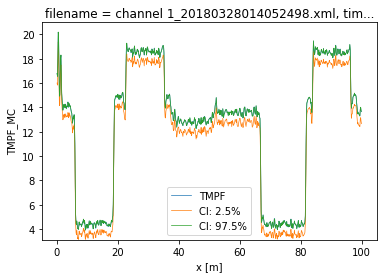

In [6]:
ds1 = ds.isel(time=0)  # take only the first timestep
ds1.TMPF.plot(linewidth=0.7)
ds1.TMPF_MC.isel(CI=0).plot(linewidth=0.7, label='CI: 2.5%')
ds1.TMPF_MC.isel(CI=1).plot(linewidth=0.7, label='CI: 97.5%')
plt.legend()
plt.show()

The DataArrays `TMPF_MC` and `TMPB_MC` and the dimension `CI` are added. `MC` stands for monte carlo and the `CI` dimension holds the confidence interval 'coordinates'.

In [7]:
ds.data_vars

Data variables:
    ST                     (x, time) float32 dask.array<shape=(787, 6), chunksize=(787, 1)>
    AST                    (x, time) float32 dask.array<shape=(787, 6), chunksize=(787, 1)>
    REV-ST                 (x, time) float32 dask.array<shape=(787, 6), chunksize=(787, 1)>
    REV-AST                (x, time) float32 dask.array<shape=(787, 6), chunksize=(787, 1)>
    TMP                    (x, time) float32 dask.array<shape=(787, 6), chunksize=(787, 1)>
    acquisitionTime        (time) float64 2.098 2.075 2.076 2.133 2.085 2.062
    referenceTemperature   (time) float64 21.05 21.05 21.05 21.05 21.05 21.06
    probe1Temperature      (time) float64 4.361 4.36 4.359 4.36 4.36 4.361
    probe2Temperature      (time) float64 18.58 18.58 18.58 18.58 18.58 18.57
    referenceProbeVoltage  (time) float64 0.1217 0.1217 0.1217 0.1217 0.1217 ...
    probe1Voltage          (time) float64 0.114 0.114 0.114 0.114 0.114 0.114
    probe2Voltage          (time) float64 0.121 0.121 0.